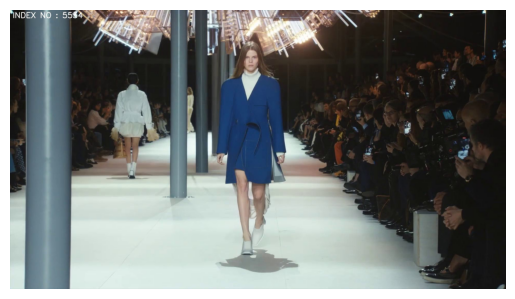

In [1]:
import os
import cv2
import matplotlib.pyplot as plt

image = cv2.imread('./mannequin_flou/person5534.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.axis('off')
plt.show()

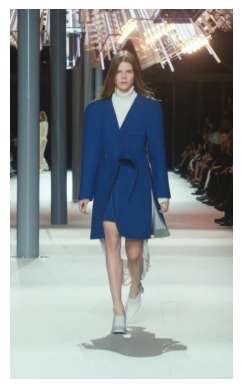

In [2]:
import os
import cv2
import matplotlib.pyplot as plt

image = cv2.imread('./mannequin_flou/person5534.jpg')
box_image_save = image[:,600:1250] # upgrade
box_image = cv2.cvtColor(box_image_save, cv2.COLOR_BGR2RGB)

plt.imshow(box_image)
plt.axis('off')
plt.show()

In [3]:
box_path = "./person5534_box.jpg"
cv2.imwrite(box_path, box_image_save)

True

In [12]:
import numpy as np
from PIL import Image
import cv2
import json
from matplotlib import pyplot as plt

In [5]:
def read_this(image_file, gray_scale=False):
    image_src = cv2.imread(image_file)
    if gray_scale:
        image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2GRAY)
#     else:
#         image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB)
    return image_src

In [6]:
def enhance_contrast(image_matrix, bins=256):
    image_flattened = image_matrix.flatten()
    image_hist = np.zeros(bins)

    # frequency count of each pixel
    for pix in image_matrix:
        image_hist[pix] += 1

    # cummulative sum
    cum_sum = np.cumsum(image_hist)
    norm = (cum_sum - cum_sum.min()) * 255
    # normalization of the pixel values
    n_ = cum_sum.max() - cum_sum.min()
    uniform_norm = norm / n_
    uniform_norm = uniform_norm.astype('int')

    # flat histogram
    image_eq = uniform_norm[image_flattened]
    # reshaping the flattened matrix to its original shape
    image_eq = np.reshape(a=image_eq, newshape=image_matrix.shape)

    return image_eq

In [7]:
def equalize_this(image_file, with_plot=False, gray_scale=False, bins=256):
    image_src = read_this(image_file=image_file, gray_scale=gray_scale)
    if not gray_scale:
        r_image = image_src[:, :, 0]
        g_image = image_src[:, :, 1]
        b_image = image_src[:, :, 2]

        r_image_eq = enhance_contrast(image_matrix=r_image)
        g_image_eq = enhance_contrast(image_matrix=g_image)
        b_image_eq = enhance_contrast(image_matrix=b_image)

        image_eq = np.dstack(tup=(r_image_eq, g_image_eq, b_image_eq))
        cmap_val = None
    else:
        image_eq = enhance_contrast(image_matrix=image_src)
        cmap_val = 'gray'

    if with_plot:
        fig = plt.figure(figsize=(10, 20))

        ax1 = fig.add_subplot(2, 2, 1)
        ax1.axis("off")
        ax1.title.set_text('Original')
        ax2 = fig.add_subplot(2, 2, 2)
        ax2.axis("off")
        ax2.title.set_text("Equalized")

        ax1.imshow(image_src, cmap=cmap_val)
        ax2.imshow(image_eq, cmap=cmap_val)
        return True, image_eq
    return image_eq

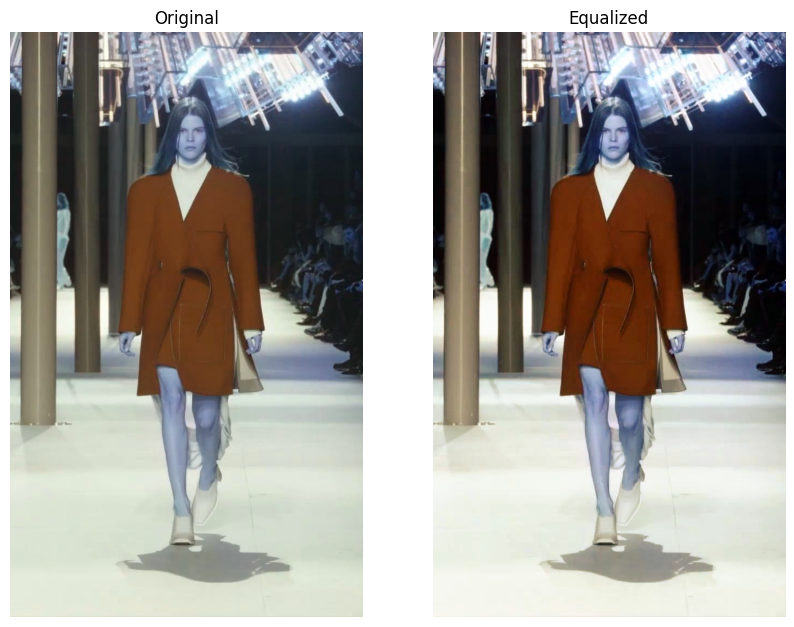

In [8]:
test, image = equalize_this(image_file="./person5534_box.jpg", with_plot=True)

In [9]:
box_path = "./person5534_equalized.jpg"
cv2.imwrite(box_path, image)

True

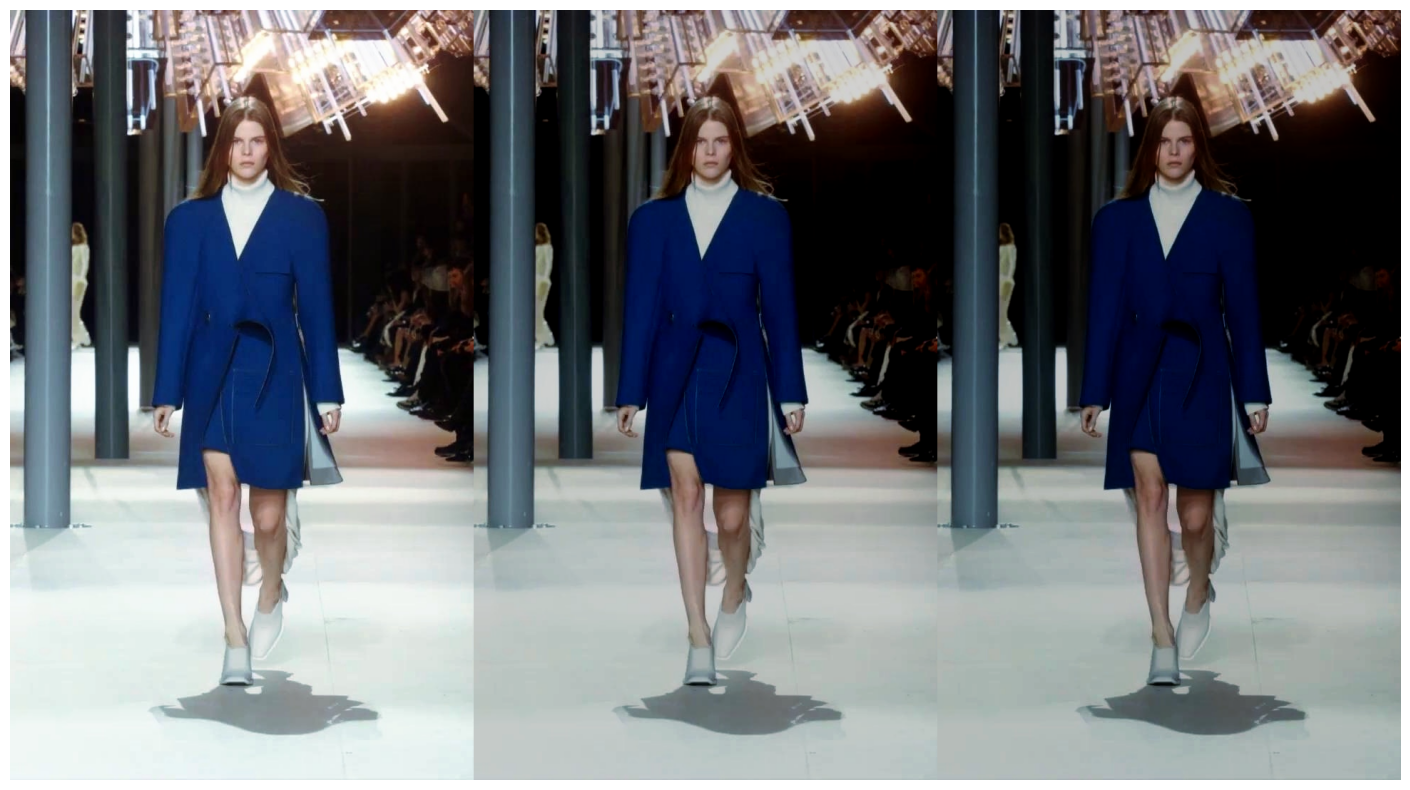

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def adjust_brightness_contrast(image, alpha, beta):
    return cv2.addWeighted(image, alpha, image, 0, beta)

def gamma_correction(image, gamma=1.0):
    # Normalize the image to the range [0, 1]
    normalized_image = image / 255.0

    # Apply gamma correction
    corrected_image = np.power(normalized_image, gamma)

    # Rescale the corrected image to [0, 255]
    corrected_image = (corrected_image * 255).astype(np.uint8)

    return corrected_image

# Load the input image
image = cv2.imread("./person5534_equalized.jpg")

# Adjust brightness and contrast
bright_image = adjust_brightness_contrast(image, 0.9, -20)

# Define the gamma value
gamma_value = 1.3

# Apply gamma correction to the bright_image
gamma_corrected_image = gamma_correction(bright_image, gamma_value)

# Stack the original, gamma corrected, enhanced, and equalized images for display
stacked_image = np.hstack((image, bright_image, gamma_corrected_image))

plt.figure(figsize=[30, 10])
plt.axis('off')
plt.imshow(cv2.cvtColor(stacked_image, cv2.COLOR_BGR2RGB))
plt.show()

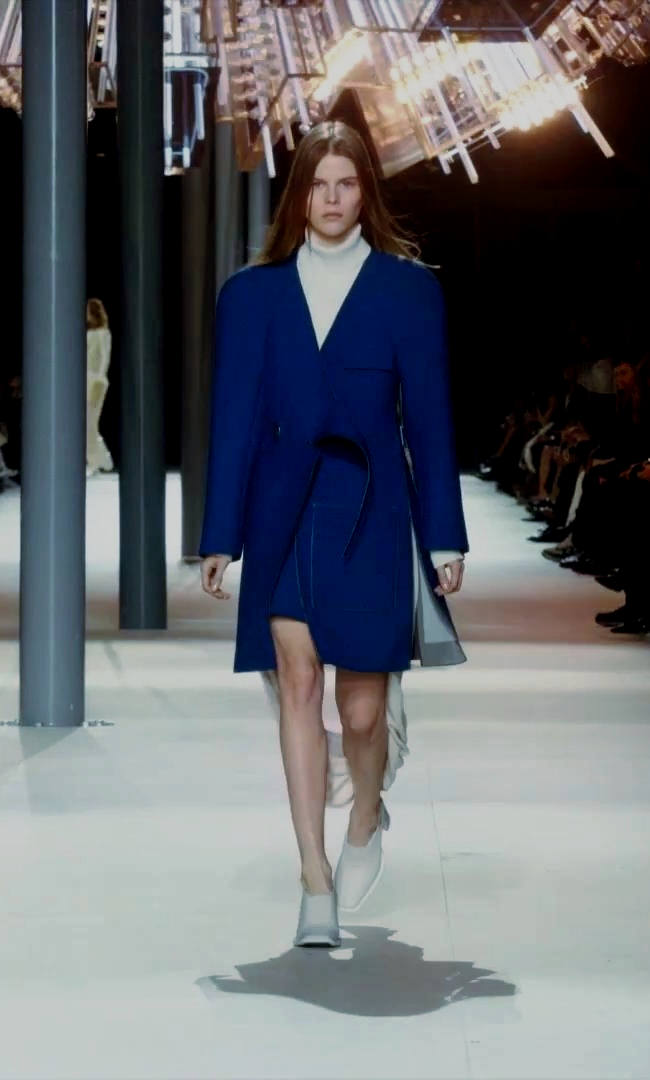

In [13]:
Image.fromarray(cv2.cvtColor(bright_image, cv2.COLOR_BGR2RGB))

In [14]:
adjust_path = "./person5534_equalized_dark.jpg"
Image.fromarray(cv2.cvtColor(bright_image, cv2.COLOR_BGR2RGB)).save(adjust_path)

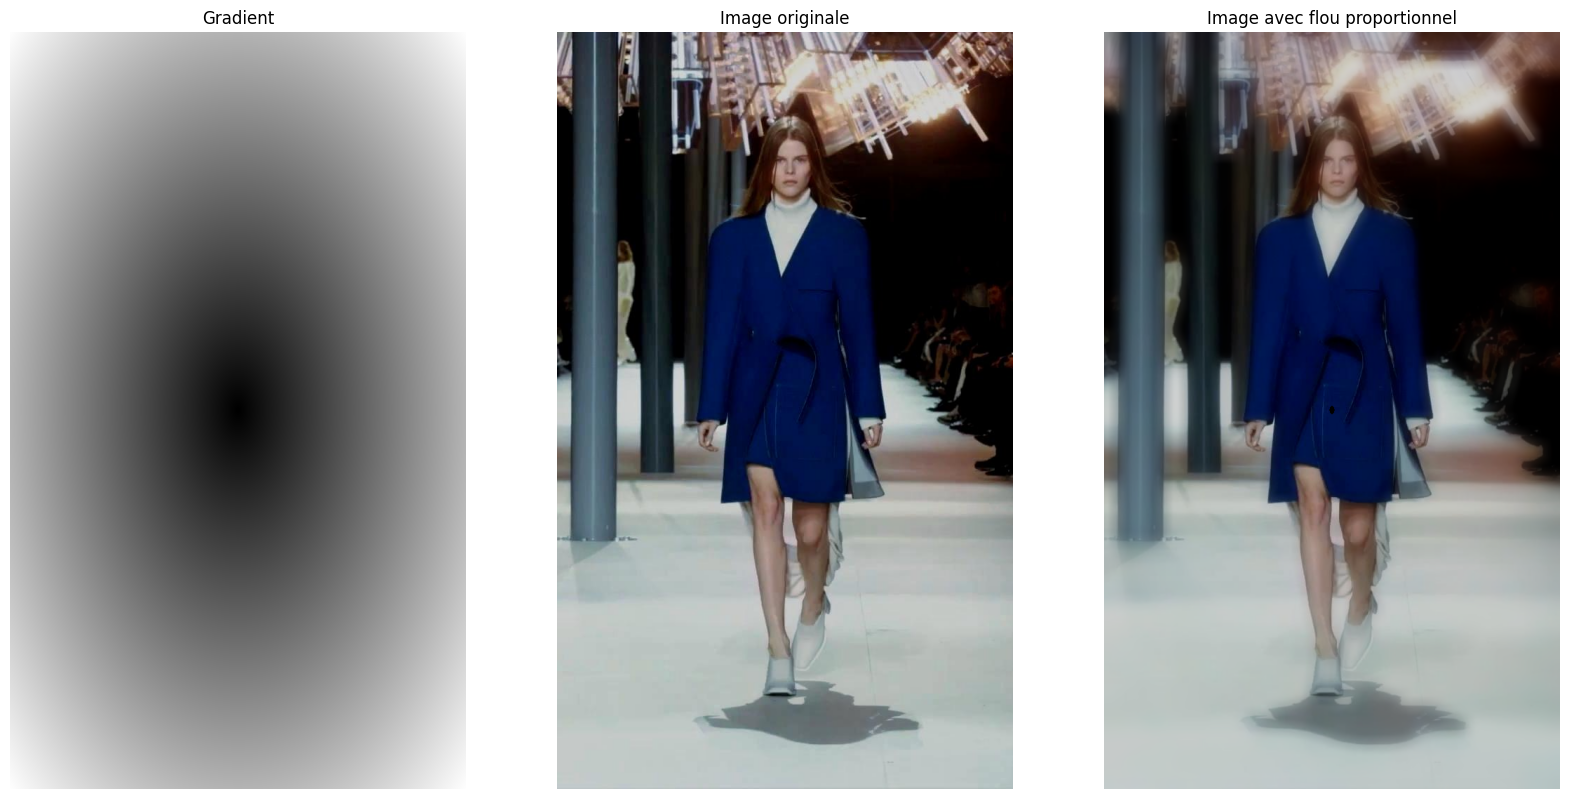

In [17]:
import numpy as np
import cv2
import math

# Define the center and radius of the circle
width = 650
height = 1080
center = [540, 325]

maxblur = 29
ramppow = 1

# read the input
img = cv2.imread("./person5534_equalized_dark.jpg")

# blur the image to the maximum desired
blur = cv2.GaussianBlur(img, (maxblur,maxblur), sigmaX=4000, sigmaY=4000)

# Note [:, None] and [None, :] specify which dimension that array will specify
# Linear ramps are between 0 and 1 and have number of increments of width or height
x = np.linspace(0, 1, width)[:, None]
y = np.linspace(0, 1, height)[None, :]

# normalize the center coordinates between 0 and 1
cx = center[1]/width
cy = center[0]/height

# Set graylevel of gradient proportional to distance from center
# Note multiply by sqrt(2) so 0 to 255 goes diagonally from center
# Include non-linear ramp power function to blur faster as get farther from the center
# Linear ramp would be ramppow=1
ramppow = 1/ramppow
gradient = np.sqrt((x-cx)**2 + (y-cy)**2)
gradient = cv2.pow(gradient,ramppow)

gradient = (255*math.sqrt(2)*gradient).clip(0,255).astype(np.uint8)
gradient = np.transpose(gradient)
gradient = cv2.merge([gradient,gradient,gradient])

# Invert the gradient
# gradient = 1 - gradient

# merge the input and blurred image using the gradient
result = ((gradient*blur.astype(np.float64) + (1-gradient)*img.astype(np.float64))/255).clip(0,255).astype(np.uint8)

# Afficher l'image originale et l'image floutée
plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.imshow(gradient)
plt.title('Gradient')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Image originale')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title('Image avec flou proportionnel')
plt.axis('off')
plt.show()

In [18]:
blur_path = "./person5534_equalized_blured.jpg"
cv2.imwrite(blur_path, result)

True

In [19]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.8/750.8 kB 19.9 MB/s eta 0:00:0000:01


In [20]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8x-seg.pt')  # load an official model

100%|██████████| 137M/137M [00:00<00:00, 218MB/s] 



image 1/1 /kaggle/working/person5534_equalized_dark.jpg: 640x416 6 persons, 2240.0ms
Speed: 8.4ms preprocess, 2240.0ms inference, 3430.5ms postprocess per image at shape (1, 3, 640, 416)


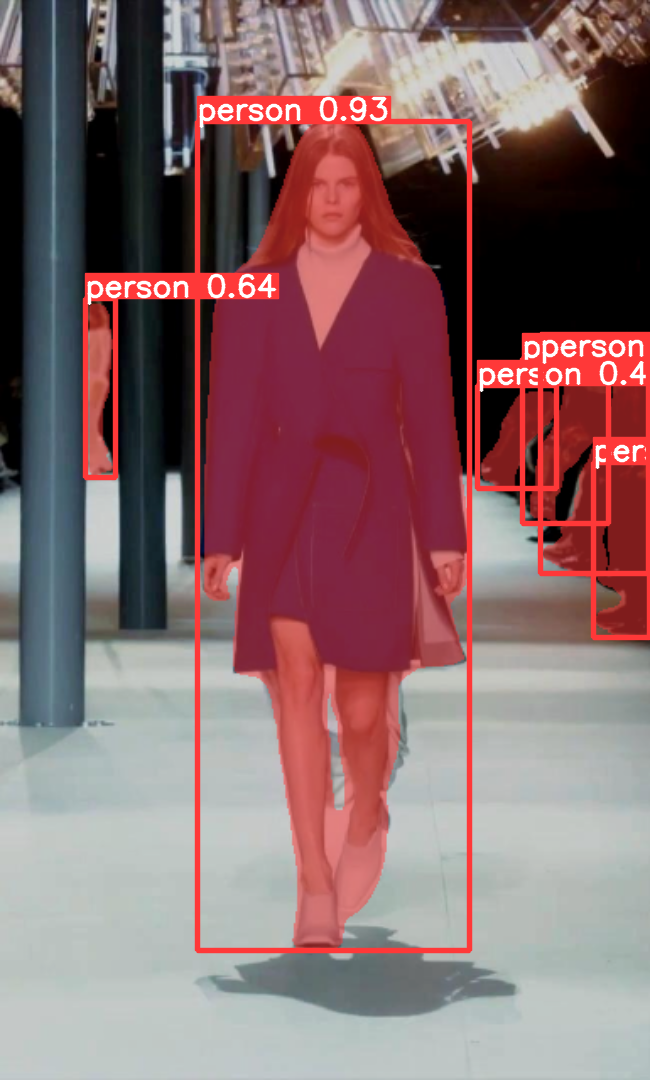

In [21]:
from PIL import Image

# Predict with the model
results = model("./person5534_equalized_dark.jpg")

plot = results[0].plot()
plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
display(Image.fromarray(plot))

In [22]:
import torch
from PIL import Image
import numpy as np
from scipy.ndimage import binary_dilation

mask_wm = results[0].masks.data[0]

# Redimensionner le tensor du masque pour qu'il corresponde aux dimensions de l'image
image_shape = (np.array(box_image).shape[0], np.array(box_image).shape[1])
mask_tensor = torch.nn.functional.interpolate(mask_wm.unsqueeze(0).unsqueeze(0), size=image_shape, mode='nearest')
mask_tensor = mask_tensor.squeeze()

# Convertir le tensor en un masque binaire numpy
mask_binary_np = (mask_tensor.cpu().detach().numpy() > 0.5).astype(np.uint8)

# Charger les images
image_path = "./person5534_equalized_dark.jpg"
image_blur_path = "./person5534_equalized_blured.jpg"

image = cv2.imread(image_path)
image_blur = cv2.imread(image_blur_path)

# Convertir les images en tableaux NumPy
image_np = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_blur_np = cv2.cvtColor(image_blur, cv2.COLOR_BGR2RGB)

# Appliquer le masque binaire sur l'image floue
masked_image = np.copy(image_blur_np)
masked_image[mask_binary_np == 1] = image_np[mask_binary_np == 1]

# # Convertir le résultat en image et l'enregistrer
# result_image = cv2.cvtColor(masked_image, cv2.COLOR_RGB2BGR)

# plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
# plt.axis('off')
# plt.show()

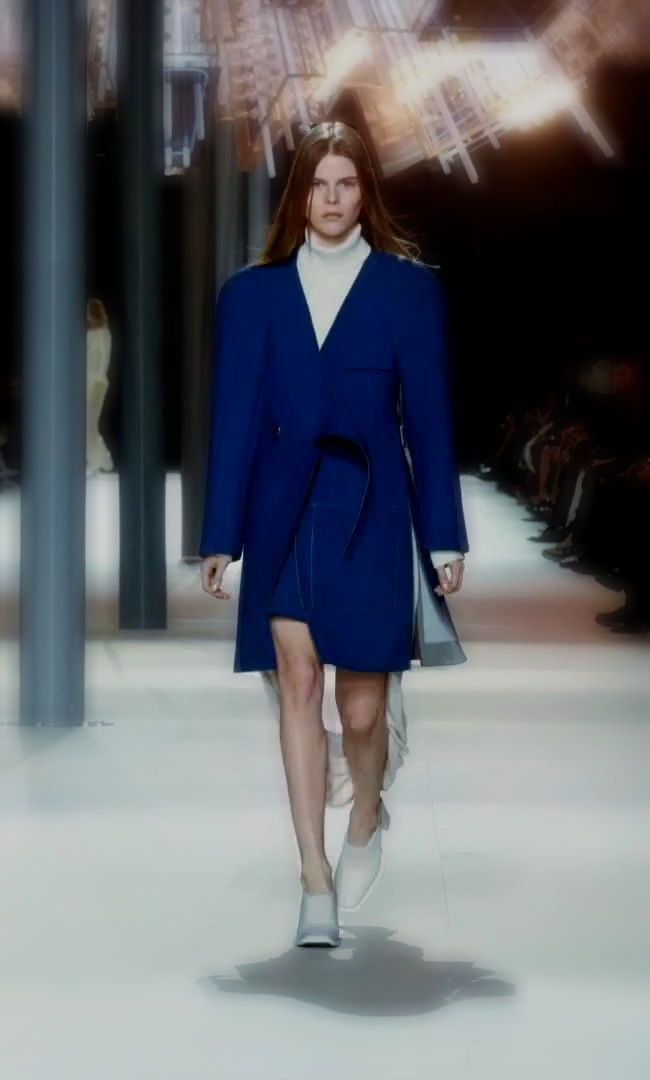

In [23]:
Image.fromarray(masked_image)

In [73]:
final_path = "./person5534_equalized_blured_final.jpg"
Image.fromarray(masked_image).save(final_path)